# Drug attrition oracle

Use this notebook to predict whether an input molecule has a potential to be withdrawn. These models were trained on molecules that have passed phase 3 clinical trials, so the majority of whithdrawal reasons were related to adverse reaction (i.e. toxic sie effects)

In [3]:
from src.dao import DrugAttritionOracle
import pandas as pd

Initialize the model

In [4]:
dao = DrugAttritionOracle()

Global seed set to 0


Model takes as input a smiles string of a molecule: e.g. azithromycin canoical smiles

In [5]:
azithromycin = "CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)C)O)(C)O"

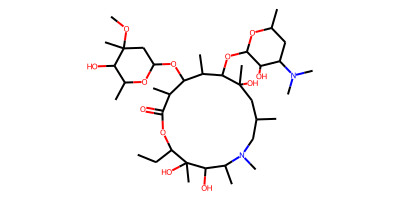

In [6]:
dao.draw_molecule(azithromycin)

You can input any format of valid SMILES, however we recommend standardizing the SMILES. (Standardization won't affect azithromycin canonical smiles)

In [7]:
standardized_azithro = dao.standardize_molecule(azithromycin)

Return the probability from the model

In [8]:
dao.predict_probability(standardized_azithro)

15.64

Predict class based on a threshold given by the optimal F1 score for the withdrawn class

In [9]:
dao.predict_class(standardized_azithro)

'Approved'

Find the probability of outputting the correct class using the conformal predictor. Without inputing a significance level the conformal method outputs a p-value, which can be interpreted as: 
  * With probability equal to the p-value, the model can produce the correct prediction

In [10]:
dao.conformal(standardized_azithro)

,Withdrawn class p-value,Approved class p-value
0,0.22,0.51


You can also enter a significance level which can be interpreted as:
   * The classifier will output a prediction with an error rate of at most equal to the specified significance level

In [11]:
dao.conformal(standardized_azithro, significance=0.05)

,Withdrawn class,Approved class
0,False,False


* We can see that the model can't make predictions that confident for this molecule

We use GNN explainer to interpret the model. It finds the edges that are most important to making the prediction for the given input molecule. This can be used to find molecular substructures importat for the prediction of withdrawn drugs. GNN explainer also outputs importance of the atom features

Explain graph: 100%|██████████| 300/300 [00:10<00:00, 28.69it/s]


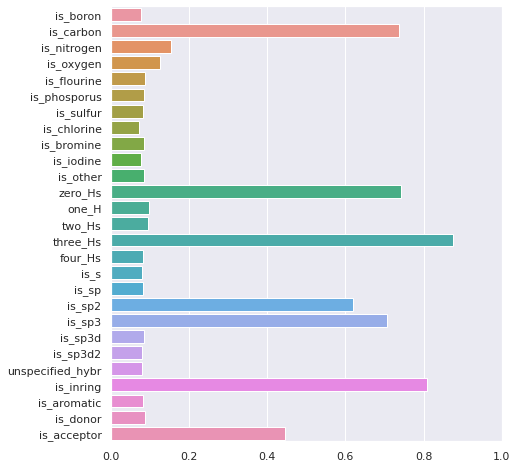

In [12]:
dao.explain_molecule_features(standardized_azithro)

Explain graph: 100%|██████████| 300/300 [00:09<00:00, 30.24it/s]


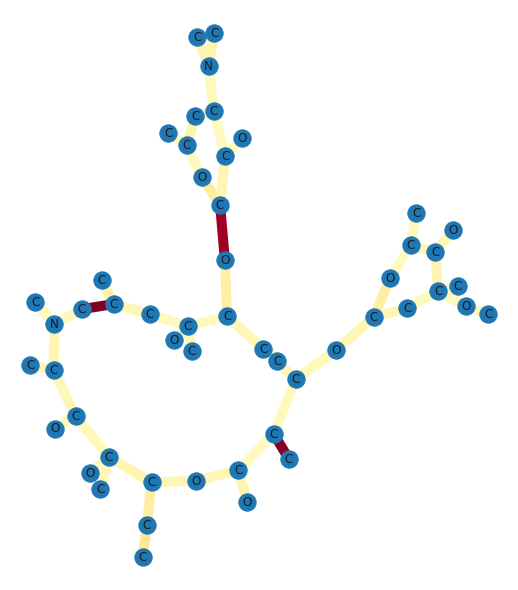

In [13]:
dao.explain_subgraphs(standardized_azithro, epochs=300)

## DAO descriptors model

In [14]:
from dao_descriptors import DrugAttritionOracleDescriptors

Model that is trained on both molecular graphs and selected molecular descriptors. Due to the size of the model it currently has to be trained on a local device.

1. Navigate to the src.descriptors folder
2. With a configured environment (from withdrawn.yml file) run:
 * python train_gcn_desc.py -production True
3. Initialize the model with the relative path (from root) to the production weights

In [15]:
dao_descriptors = DrugAttritionOracleDescriptors(
    'production/ozren_selected/checkpoint/epoch=7-step=455.ckpt'
)

Global seed set to 0


In [25]:
pinacidil = "CC(C(C)(C)C)N=C(NC#N)NC1=CC=NC=C1"

The model has the same functionalities as the model without descriptors, however for input it expects a dataframe of descriptors (Padel 1560 fingerprints and ToxPrint descriptors), where the column names are the descriptors.
* For pinacidil molecule the input would look like 

In [22]:
padel = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/descriptors/padel1560_descriptors.csv')
toxprint = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/descriptors/toxprint_descriptors.csv')
padel = padel.loc[padel['chembl_id'] == 'CHEMBL1159']
toxprint = toxprint.loc[toxprint['chembl_id'] == 'CHEMBL1159']
descriptors = padel.merge(toxprint, how='inner', on='chembl_id', suffixes=[None, '_rightdf']) #important to be able to find the right descriptors
descriptors 

,Unnamed: 0,chembl_id,AD2D1,AD2D2,AD2D3,AD2D4,AD2D5,AD2D6,AD2D7,AD2D8,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,319,CHEMBL1159,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* It is important to remember that the input requires a specific subset of all alvaDesc descriptors. You can input all descriptors generate by alvaDesc and the DAO will automatically select the ones the model requires.

In [26]:
dao_descriptors.predict_class(pinacidil, descriptors=descriptors)

'Approved'

In [27]:
dao_descriptors.predict_probability(pinacidil, descriptors=descriptors)

13.23

* Currently interpretation methods are available only for the model without descriptors due to the code of the GNN explainer

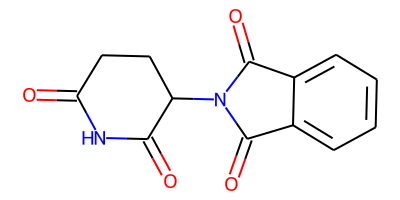

In [31]:
dao.draw_molecule(r"O=C3CCC(N2C(=O)c1ccccc1C2=O)C(=O)N3")

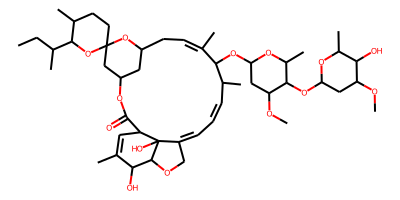

In [32]:
dao.draw_molecule("CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC5C4(C(C=C(C5O)C)C(=O)O3)O)C)OC6CC(C(C(O6)C)OC7CC(C(C(O7)C)O)OC)OC)C)C")

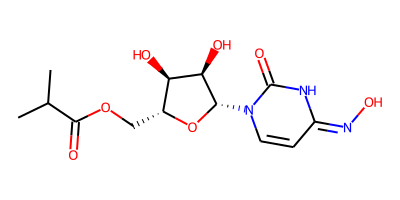

In [28]:
dao.draw_molecule(r"CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N2C=C\C(=N\O)\NC2=O")